In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pathlib


In [2]:
image_path = pathlib.Path("/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset")

In [3]:
image_count = len(list(image_path.glob('*/*.jpg')))
print(image_count)

254


In [4]:
images = []
label = []

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
for gender_dir in os.listdir(image_path):
    if gender_dir == 'men':
        gender = 0 
    else:
        gender = 1
    gender_path = os.path.join(image_path, gender_dir)
    
    for filename in os.listdir(gender_path):
        image_file = os.path.join(gender_path, filename)
        images.append(image_file)  # Add the image file path to the list
        label.append(gender)  


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    image_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 279 files belonging to 2 classes.
Using 224 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  image_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 279 files belonging to 2 classes.
Using 55 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['men', 'women']


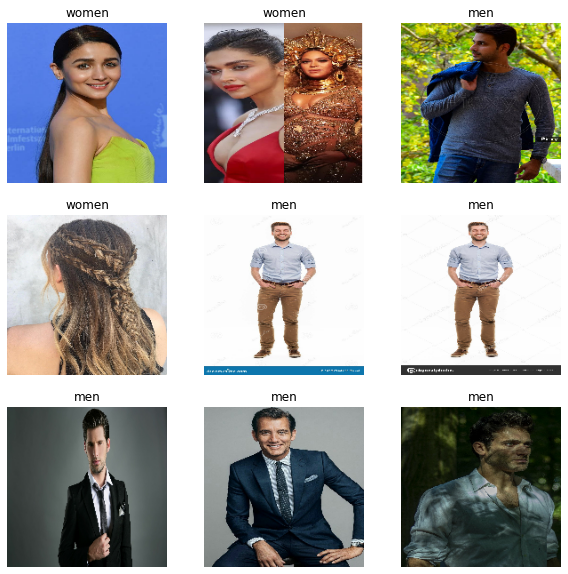

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])

            plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 2
    
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
7/7 [==============================] - 6s 643ms/step - loss: 0.8082 - accuracy: 0.4777 - val_loss: 0.6239 - val_accuracy: 0.6727
Epoch 2/5
7/7 [==============================] - 2s 315ms/step - loss: 0.6564 - accuracy: 0.5402 - val_loss: 0.6356 - val_accuracy: 0.8000
Epoch 3/5
7/7 [==============================] - 3s 497ms/step - loss: 0.6091 - accuracy: 0.7545 - val_loss: 0.5898 - val_accuracy: 0.7636
Epoch 4/5
7/7 [==============================] - 2s 354ms/step - loss: 0.4863 - accuracy: 0.8080 - val_loss: 0.7388 - val_accuracy: 0.5818
Epoch 5/5
7/7 [==============================] - 3s 342ms/step - loss: 0.4343 - accuracy: 0.8080 - val_loss: 0.6326 - val_accuracy: 0.6545


In [18]:
test_loss, test_accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", test_accuracy)

2/2 [==============================] - 0s 54ms/step - loss: 0.6326 - accuracy: 0.6545
Validation Accuracy: 0.6545454263687134


In [20]:
list_ds = tf.data.Dataset.list_files(str(image_path/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset/men/Image_112.jpg'
b'/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset/men/Image_72.jpg'
b'/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset/women/Image_21.jpg'
b'/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset/men/Image_120.jpg'
b'/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset/men/Image_70.jpg'


In [22]:
class_names = np.array(sorted([item.name for item in image_path.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['men' 'women']


In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

229
50


In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [28]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [30]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

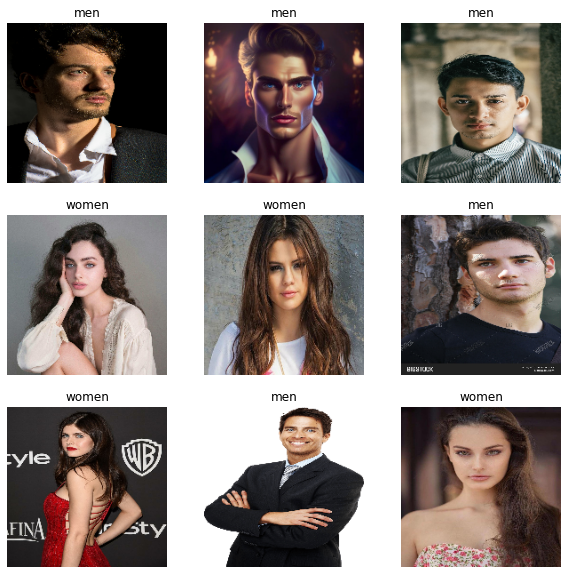

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [32]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
8/8 [==============================] - 4s 452ms/step - loss: 0.5933 - accuracy: 0.6507 - val_loss: 0.4693 - val_accuracy: 0.8800
Epoch 2/5
8/8 [==============================] - 3s 401ms/step - loss: 0.5076 - accuracy: 0.7642 - val_loss: 0.4214 - val_accuracy: 0.8200
Epoch 3/5
8/8 [==============================] - 2s 298ms/step - loss: 0.3644 - accuracy: 0.8821 - val_loss: 0.3730 - val_accuracy: 0.8200
Epoch 4/5
8/8 [==============================] - 2s 276ms/step - loss: 0.3125 - accuracy: 0.8690 - val_loss: 0.3465 - val_accuracy: 0.8800
Epoch 5/5
8/8 [==============================] - 3s 427ms/step - loss: 0.2668 - accuracy: 0.8952 - val_loss: 0.3896 - val_accuracy: 0.7800


In [34]:
test_loss, test_accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", test_accuracy)

2/2 [==============================] - 0s 217ms/step - loss: 0.3896 - accuracy: 0.7800
Validation Accuracy: 0.7799999713897705


In [54]:
model.save('gender_detection_trained_model.h5')

In [58]:
'''def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    print(f"Predicted: {class_names[predicted_class]}")

# Test on a sample image from the men or women folder
predict_image("/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset/men/Image_100.jpg")
predict_image("/home/vetri/Documents/Open_CV/gender_age_detection/gender_dataset/women/Image_122.jpg")
'''

Predicted: men
Predicted: women


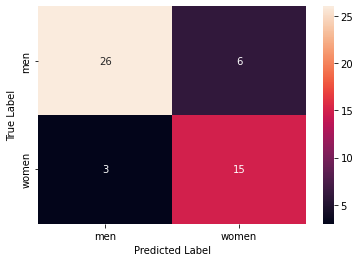

In [59]:
'''from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for validation dataset
y_pred = []
y_true = []

for image_batch, label_batch in val_ds:
    preds = model.predict(image_batch)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(label_batch.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
'''

In [60]:
'''history = model.fit(train_ds, validation_data=val_ds, epochs=5)
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
print(f'Training Accuracy: {training_accuracy[-1]}')
print(f'Validation Accuracy: {validation_accuracy[-1]}')
'''

Epoch 1/5
8/8 [==============================] - 2s 244ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.8402 - val_accuracy: 0.8000
Epoch 2/5
8/8 [==============================] - 2s 246ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8457 - val_accuracy: 0.8000
Epoch 3/5
8/8 [==============================] - 2s 247ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8399 - val_accuracy: 0.8200
Epoch 4/5
8/8 [==============================] - 2s 244ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.8535 - val_accuracy: 0.8200
Epoch 5/5
8/8 [==============================] - 2s 258ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.8808 - val_accuracy: 0.8000
Training Accuracy: 1.0
Validation Accuracy: 0.800000011920929
